In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
rpt_financial_varibles=pd.read_csv('rpt_fv.csv')
rpt=pd.read_csv('listed_RPT.csv')


In [4]:
rpt_financial_varibles=pd.read_csv('rpt_fv.csv')
rpt=pd.read_csv('listed_RPT.csv')
triples={}
###增加 关联交易（RPT） 关系
for i in rpt.index:
    
    year=str(rpt.loc[i,'tradeYear'])
    t=tuple([year+'.comp.'+str(rpt.loc[i,'cp1']),'RPT',year+'.comp.'+str(rpt.loc[i,'cp2'])])
    triples[t]=1
from tqdm import tqdm
tmpT=np.array([list(i) for i in list(triples.keys())])
X=[list(i) for i in list(triples.keys())]
###增加company meta关系
for i in tqdm(range(len(tmpT))):
    c1=tmpT[i][0]
    t=[c1,'meta.company','meta.comp.'+str(c1.split('.')[2])]
    if t not in X:
        X.append(t)



100%|██████████| 12048/12048 [00:09<00:00, 1282.68it/s]


In [12]:
X=X+manager_triples
from sklearn.model_selection import train_test_split
train_ids,test_ids=train_test_split(range(len(X)),test_size=0.05)
train_ids,val_ids=train_test_split(train_ids,test_size=0.1)
X=np.array(X)
pd.DataFrame(X[train_ids]).to_csv('./dglke_dataset/KG5/train.txt',index=None,header=None,sep='\t')
pd.DataFrame(X[val_ids]).to_csv('./dglke_dataset/KG5/valid.txt',index=None,header=None,sep='\t')
pd.DataFrame(X[test_ids]).to_csv('./dglke_dataset/KG5/test.txt',index=None,header=None,sep='\t')



In [15]:
len(set(X[:,1]))

45

KG5: 公司类别变量+董监高人员（时序节点包括时间和公司信息，元节点只包括人员编码）+董监高人员特征


 7322041 triples，512251 entities，45 relations
 

In [2]:
import json
with open('KG4.json') as f:
    X=json.load(f)

In [5]:
###增加分类类别关系
industry_triples=[]
for i in tqdm(rpt_financial_varibles.index):
    
    code=rpt_financial_varibles.loc[i,'Stkcd']
    ind='ind.'+str(rpt_financial_varibles.loc[i,'IndustryCode'])
    industry_triples.append(['meta.comp.'+str(code),'industry',ind])
X+=industry_triples
categories=['Big4','Outside','OneControlMany','MngmFinancialBack','MngmOverseaBack',
'IsCocurP','ConcurrentPosition','ISHoldOtherFinaShares','ISHoldOtherFinaShares','ISHoldBankShares','ContrshrNature','PropertyRightsNature']
category_triples=[]
for i in tqdm(rpt_financial_varibles.index):
    year=rpt_financial_varibles.loc[i,'year']
    code=rpt_financial_varibles.loc[i,'Stkcd']
    for c in categories:
        c_v=rpt_financial_varibles.loc[i,c]
        category_triples.append([str(year)+'.comp.'+str(code),'cat.'+c,c+'.'+str(c_v)])
X+=category_triples

100%|██████████| 9366/9366 [00:02<00:00, 3766.97it/s]


In [6]:
###董事会信息
manager=pd.read_csv('./borad.csv')
manager=manager.loc[[i in rpt_financial_varibles['Stkcd'] for i in manager['Stkcd']]]

In [7]:
manager['Age']=manager['Age'].apply(lambda x: '20-40' if x<=40 else '40-60' if x<=60 else '60-')
manager=manager.sort_values(by='year',ascending=True)

In [8]:
from tqdm import tqdm
meta_column=['Gender','Age','University','Degree','Major','Funback','OveseaBack','Academic','FinBack']
manager_triples=[]
flag=[]
cols=manager.columns.drop(['Stkcd','Reptdt','year','PersonID','Name']+meta_column)
for i in tqdm(manager.index):
    p_id=manager.loc[i,'PersonID']
    meta_p='meta.person.'+str(p_id)
    year_p=str(manager.loc[i,'year'])+'.person.'+str(p_id)+'.comp.'+str(manager.loc[i,'Stkcd'])
    manager_triples.append([year_p,'meta.person',meta_p])
    year_comp=str(manager.loc[i,'year'])+'.comp.'+str(manager.loc[i,'Stkcd'])
    manager_triples.append([year_comp,'has_manager',year_p])
    for c in cols:
        items=manager.loc[i,c]
        if isinstance(items,str):
            for item in items.split(','):
                t=[year_p,'manager.'+str(c),str(c)+'.'+str(item)]
                manager_triples.append(t)
        elif  np.isnan(items):
            continue
        else:
            t=[year_p,'manager.'+str(c),str(c)+'.'+str(item)]
            manager_triples.append(t)

        

100%|██████████| 385562/385562 [02:57<00:00, 2169.02it/s]


In [9]:
flag=[]
meta_manager_triples=dict()
for i in tqdm(manager.index):
    p_id=manager.loc[i,'PersonID']
    meta_p='meta.person.'+str(p_id)
    year_p=str(manager.loc[i,'year'])+'.person.'+str(p_id)+'.comp.'+str(manager.loc[i,'Stkcd'])
    for c in meta_column:
        items=manager.loc[i,c]
        if isinstance(items,str) :
            for item in items.split(','):
                t=[meta_p+'$manager.'+str(c),str(c)+'.'+str(item)]
                meta_manager_triples[t[0]]=t[1]
        elif np.isnan(items):
            continue
        else:
            t=[meta_p+'$manager.'+str(c),str(c)+'.'+str(item)]
            meta_manager_triples[t[0]]=t[1]
        

100%|██████████| 385562/385562 [01:13<00:00, 5279.53it/s]


In [10]:
for key in tqdm(meta_manager_triples.keys()):
        manager_triples.append([key.split('$')[0],key.split('$')[1],meta_manager_triples[key]])

100%|██████████| 451377/451377 [00:00<00:00, 615763.12it/s]


In [11]:
del meta_manager_triples

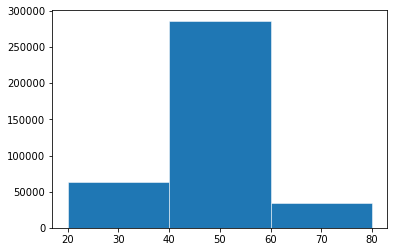

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x=manager['Age'].dropna()
ax.hist(x, bins=[20,40,60,80], linewidth=0.5, edgecolor="white")

plt.show()

In [3]:
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
rpt=pd.read_csv('listed_RPT.csv')
rpt['in_node']=rpt.apply(lambda x:str(x['tradeYear'])+'.comp.'+str(x['cp2']),axis=1)
rpt['out_node']=rpt.apply(lambda x:str(x['tradeYear'])+'.comp.'+str(x['cp1']),axis=1)
rpt=rpt.loc[rpt.apply(lambda x:x['in_node']!=x['out_node'] and x['in_node'] in node_list.values and x['out_node'] in node_list.values,axis=1)]
rpt_edges=rpt.groupby(['in_node','out_node']).apply(len)
rpt_edges.to_csv('RPT.csv')


In [ ]:
rpt_graph=nx.Graph(name='RPT')
rpt_graph.add_edges_from(rpt_edges)
cc=nx.connected_components(rpt_graph)
cc_len=[]
for c in cc:
    cc_len.append(len(c))

print('number of cc:{}'.format(len(cc_len)))
print('average size of cc:{}'.format(np.average(cc_len)))
print('cc:{}'.format(cc_len))

In [14]:
rpt_year=pd.read_csv('KG1.csv')
rpt_year=rpt_year.loc[rpt_year.apply(lambda x: x['0'] in node_list.values and x['2'] in node_list.values,axis=1)]
rpt_year_edges=rpt_year[['0','2']].values

In [ ]:
rpt_year_graph=nx.Graph(name='RPT')
rpt_year_graph.add_edges_from(rpt_year_edges)
cc=nx.connected_components(rpt_year_graph)
cc_len=[]
for c in cc:
    cc_len.append(len(c))

print('number of cc:{}'.format(len(cc_len)))
print('average size of cc:{}'.format(np.average(cc_len)))
print('cc:{}'.format(cc_len))

In [24]:
largest_cc = list(max(nx.connected_components(rpt_year_graph), key=len))

In [56]:
from tqdm import  tqdm
mm=pd.read_csv('sameYearManager.csv')
mm=mm.loc[mm.apply(lambda x:x['0']!=x['2'],axis=1)]
mm_edges=mm[['0','2']].values
tmpT=mm_edges
X=[]
###增加 the same company 关系
for i in tqdm(range(len(tmpT))):
    c1=tmpT[i][0]
    c1_n_set=[]
    for j in range(len(tmpT)):
        c2=tmpT[j][0]
        c3=tmpT[j][1]
        if c2!=c1 and c1[4:]==c2[4:]:
            t=int(c2[0:4])
            if t not in c1_n_set and t<int(c1[0:4]):
                
                c1_n_set.append(t)
        if c3!=c1 and c1[4:]==c3[4:]:
            t=int(c3[0:4])
            if t not in c1_n_set and t<int(c1[0:4]):
                c1_n_set.append(t)
    if len(c1_n_set)!=0:
        t=[c1,'year.previous',str(max(c1_n_set))+c1[4:]]
        if t not in X:
            X.append(t)

100%|██████████| 10639/10639 [02:00<00:00, 88.08it/s]


In [68]:
edges2=np.array(mm.values.tolist()+X+[[i[0],'rpt',i[1]] for i in rpt_edges])

In [4]:
import pandas as pd
f=pd.read_csv('RT_SC_B_features.csv')[['Stkcd','year']]
node_list=f.apply(lambda x:str(x['year'])+'.comp.'+str(x['Stkcd']),axis=1)

In [80]:
edges3=edges2[[i[0] in node_list.values and i[2] in node_list.values for i in edges2]]
pd.DataFrame(edges3).to_csv('KG6.csv',index=False)

In [13]:

import networkx as nx
from tqdm import  tqdm
import numpy as np
mm0=pd.read_csv('sameManager.csv')
mm=mm0.loc[mm0.apply(lambda x:x['0']!=x['2'] and x['0'] in node_list.values and x['2'] in node_list.values,axis=1)]
mm_edges=mm[['0','2']].values
G=nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(np.array(mm_edges))

In [19]:
G=nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(np.array(mm_edges))

In [21]:
G.add_edges_from(rpt_edges)

In [5]:
mm_graph=nx.Graph(name='mm')
mm_graph.add_edges_from(mm_edges) 
cc=nx.connected_components(mm_graph)
cc_len=[]
for c in cc:
    cc_len.append(len(c))

print('number of cc:{}'.format(len(cc_len)))
print('average size of cc:{}'.format(np.average(cc_len)))
print('cc:{}'.format(cc_len))

number of cc:15
average size of cc:621.8
cc:[9274, 19, 2, 6, 2, 2, 4, 3, 2, 2, 2, 3, 2, 2, 2]


In [32]:
adj=nx.adjacency_matrix(G)

In [15]:
adj=nx.adjacency_matrix(G)
import scipy.sparse as sp
sp.save_npz('./HSM.npz',adj)

In [31]:
adj=sp.coo_matrix(adj)

In [10]:
a=adj.toarray()

In [4]:
G.add_edges_from(rpt_year_edges)

In [15]:
mm_graph=nx.Graph(name='mm')
mm_graph.add_edges_from(mm_edges) 
cc=nx.connected_components(mm_graph)
cc_len=[]
for c in cc:
    cc_len.append(len(c))

print('number of cc:{}'.format(len(cc_len)))
print('average size of cc:{}'.format(np.average(cc_len)))
print('cc:{}'.format(cc_len))

number of cc:15
average size of cc:621.8
cc:[9274, 19, 2, 6, 2, 2, 4, 3, 2, 2, 2, 3, 2, 2, 2]


In [22]:
adj3=nx.adjacency_matrix(G)

In [ ]:
import scipy.sparse as sp
import pandas as pd
sp.save_npz('./RPT_HSM.npz',adj3)

In [16]:
manager=pd.read_csv('borad.csv')

In [17]:
manager['p_node']=manager.apply(lambda x:'.person.'+x['PersonID'],axis=1)
manager['c_node']=manager.apply(lambda x:x['Reptdt'][0:4]+'.comp.'+str(x['Stkcd']),axis=1)
manager=manager[['p_node','c_node']]

In [18]:
import networkx as nx
G=nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(manager.values)

In [9]:
a=G.nodes

In [19]:
adj=nx.adjacency_matrix(G)
adj=adj.dot(adj)

In [20]:
adj=adj[0:9366,0:9366]


In [21]:
adj[0,3]

5

In [22]:
import scipy.sparse as sp
for i in range(0,9366):
    adj[i,i]=0
sp.save_npz('./sameManager.npz',adj)

In [17]:
G=nx.from_scipy_sparse_matrix(adj)

In [24]:
e=G.adj

In [25]:
from tqdm import tqdm
sm_edges=[]
for k in e.keys():
    k_dict=e[k]
    for sub_k in k_dict.keys():
        sm_edges.append([node_list[k],node_list[sub_k],k_dict[sub_k]['weight']])

In [26]:
pd.DataFrame(sm_edges,columns=['comp1','comp2','w']).to_csv('sameManager.csv')

In [27]:
node_list.to_csv('node_list.csv')

In [5]:
G=nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(rpt_edges.index.values)

In [4]:
node_list=list(node_list)

In [7]:
from tqdm import tqdm
adj=nx.adjacency_matrix(G)
for e in tqdm(rpt_edges.index):
    i=node_list.index(e[0])
    j=node_list.index(e[1])
    adj[i,j]=rpt_edges.loc[e[0]][e[1]]

100%|██████████| 8586/8586 [00:03<00:00, 2326.18it/s]


In [8]:
import scipy.sparse as sp
sp.save_npz('./rpt.npz',adj)